In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import pdb
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from itertools import product

df = pd.read_csv('structure.csv')
df_input = pd.read_csv('structure_input.csv')

n = 10 # This is the assumed sampling number
# wは制御因子, xは誤差因子
x_labels = [c for c in df.columns if 'x' in c]
w_u_labels = [c for c in df.columns if 'w' in c]
# w_u_labels_dict = {}
# for w_u_label in w_u_labels:
#     w = w_u_label.split(':')[0]
#     u = w_u_label.split(':')[1]
#     if not w in w_u_labels_dict:
#         w_u_labels_dict[w] = [u]
#     else:
#         w_u_labels_dict[w].append(u)
w_labels = [w_u_label.split(':')[0] for w_u_label in w_u_labels]
u_labels = [w_u_label.split(':')[1] for w_u_label in w_u_labels]
df_error = df[w_u_labels]
df_control = df[x_labels]

N = len(df) # 8
N_x = len(x_labels)
N_w = len(w_labels)


In [3]:
u_labels

['u1', 'u1', 'u2', 'u2']

In [4]:
df_input

,u1,u2
0,50,200


In [5]:
beta = [0]*N #感度
ST = 0 #全変動
Sbeta = [0]*N #回帰変動
SE = [0]*N  #残差変動
SN = [0]*N  #SN比
import pdb
for i, row in df_error.iterrows():
    num = 0
    den = 0
    for j, r in enumerate(row):
        u = df_input[u_labels[j]]
        num = num + u*r
        den = den + u**2
    beta[i] = num/den
    ST = sum([r**2 for r in row])
    Sbeta[i] = beta[i]**2 * den 
    SE[i] = ST - Sbeta[i]
    SN[i] = 10*math.log10(Sbeta[i]/SE[i])

In [6]:
# 改善すべき因子の抽出 (第一段階: SN比を利用)
SN_mean_difference = [0]*N_x
sn_mean_a = [0]*N_x
sn_mean_b = [0]*N_x
sn_mean_c = [0]*N_x
for i in range(N_x):
    x = x_labels[i]
    df_x = df_control[x]
    for j, _ in enumerate(SN):
        if df_x[j]==1:
            sn_mean_a[i] += SN[j]
        elif df_x[j]==2:
            sn_mean_b[i] += SN[j]
        elif df_x[j]==3:
            sn_mean_c[i] += SN[j]
    sn_mean_a[i] = sn_mean_a[i] / (N/3)
    sn_mean_b[i] = sn_mean_b[i] / (N/3)
    sn_mean_c[i] = sn_mean_c[i] / (N/3)
    SN_mean_difference[i] = max(sn_mean_a[i],sn_mean_b[i],sn_mean_c[i]) \
                         - min(sn_mean_a[i],sn_mean_b[i],sn_mean_c[i])
   

In [50]:
# 目標値のあわせこみ(第二段階: 感度を利用)
Mean_beta_difference = [0]*N_x
mean_beta_a = [0]*N_x
mean_beta_b = [0]*N_x
mean_beta_c = [0]*N_x
for i in range(N_x):
    x = x_labels[i]
    df_x = df_control[x]
    for j, b in enumerate(beta):
        if df_x[j]==1:
            mean_beta_a[i] += b
        elif df_x[j]==2:
            mean_beta_b[i] += b
        elif df_x[j]==3:
            mean_beta_c[i] += b
    mean_beta_a[i] = mean_beta_a[i] / (N/3)
    mean_beta_b[i] = mean_beta_b[i] / (N/3)
    mean_beta_c[i] = mean_beta_c[i] / (N/3)
    Mean_beta_difference[i] = \
              np.max((mean_beta_a[i],mean_beta_b[i],mean_beta_c[i])) - \
              np.min((mean_beta_a[i],mean_beta_b[i],mean_beta_c[i]))


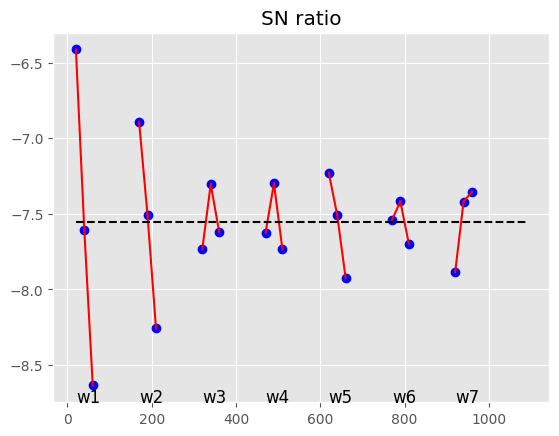

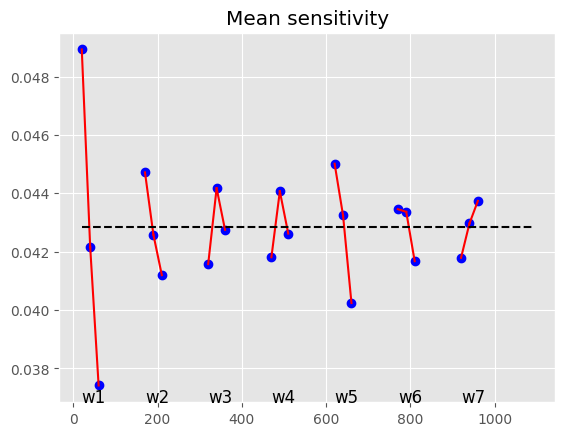

In [51]:
# 要因効果図の描画
offset = 150 
initial_x = 20
width = 20
x_a = [initial_x]
x_b = [initial_x+width]
x_c = [initial_x+2*width]
# x座標生成
for i in range(N_x):
    x_a.append(x_a[-1]+offset)
    x_b.append(x_b[-1]+offset)
    x_c.append(x_c[-1]+offset)

plt.figure(1)
plt.title("SN ratio")
plt.figure(2)
plt.title("Mean sensitivity")

# 要因効果図の描画
for i in range(N_x):
    sn_a = sn_mean_a[i]
    sn_b = sn_mean_b[i]
    sn_c = sn_mean_c[i]
    plt.figure(1)
    plt.plot(x_a[i],sn_a,'bo')
    plt.plot(x_b[i],sn_b,'bo')
    plt.plot(x_c[i],sn_c,'bo')
    plt.plot((x_a[i],x_b[i]),(sn_a,sn_b),'r')
    plt.plot((x_b[i],x_c[i]),(sn_b,sn_c),'r')

    mean_a = mean_beta_a[i]
    mean_b = mean_beta_b[i]
    mean_c = mean_beta_c[i]
    plt.figure(2)
    plt.plot(x_a[i],mean_a,'bo')
    plt.plot(x_b[i],mean_b,'bo')
    plt.plot(x_c[i],mean_c,'bo')
    plt.plot((x_a[i],x_b[i]),(mean_a,mean_b),'r')
    plt.plot((x_b[i],x_c[i]),(mean_b,mean_c),'r')

# 平均値の描画
sn_average = pd.DataFrame(SN).mean()
mean_beta = pd.DataFrame(beta).mean()
plt.figure(1)
plt.plot((x_a[0],x_b[-1]),(sn_average,sn_average),'k--')
plt.figure(2)
plt.plot((x_a[0],x_b[-1]),(mean_beta,mean_beta),'k--')

# ラベルの描画
for i in range(N_x):
    plt.figure(1)
    axes = plt.gca()
    yl = axes.get_ylim()[0]
    plt.text(x_a[i], yl, 'w'+str(i+1), fontsize=12)

    plt.figure(2)
    axes = plt.gca()
    yl = axes.get_ylim()[0]
    plt.text(x_a[i], yl, 'w'+str(i+1), fontsize=12)

plt.show(block=False)

#input("Press Enter to exit.")
